Titanic dataset purpose - to predict the survival rate 

In [88]:
from string import ascii_letters
import numpy as np
import pandas as pd
import scipy
import re

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF
import plotly.express as px


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV



In [49]:
# Read the dataset 
ds_titanic_src = pd.read_csv('train.csv', index_col='PassengerId')
ds_titanic_test = pd.read_csv('test.csv', index_col='PassengerId')
(rec, cols) = ds_titanic_src.shape
print("""Total records: {0}
Total columns: {1}""".format(rec,cols))
ds_titanic_src.describe()


Total records: 891
Total columns: 11


Survived      Pclass         Age       SibSp       Parch        Fare
count  891.000000  891.000000  714.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642   29.699118    0.523008    0.381594   32.204208
std      0.486592    0.836071   14.526497    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%      0.000000    2.000000   20.125000    0.000000    0.000000    7.910400
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000   38.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200

In [50]:
#first, let's decide which columns to keep, and which to drop
stats = ds_titanic_src.apply(lambda col: sum(col.isnull()/len(ds_titanic_src)))
stats

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [51]:
stats = stats[stats > 0.0]
for i in stats.index:
    print(i)

Age
Cabin
Embarked


In [52]:
#Cabin: this column has the highest missing rate 77%, let's drop it
ds_titanic_src2 = ds_titanic_src.drop('Cabin', axis=1)
ds_titanic_test = ds_titanic_test.drop('Cabin', axis=1)
ds_titanic_src2.head()

Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Embarked  
PassengerId                                                    
1                1      0         A/5 21171   7.2500        S  
2                1      0          PC 17599  71.2833        C  
3                0      0  STON/O2. 3101282   7.9250        S  
4                1      0            113803  53.1000        S  
5                0      0            373450   8.0500        S

In [53]:
# Age: this column has about 19.8% missing rate, there are several thought on imputing them
# method 1: replace with the most frequent value  
age = ds_titanic_src2['Age'].value_counts().index[0]
ds_titanic_src2['Age'] = ds_titanic_src2['Age'].fillna(age)
ds_titanic_test['Age'] = ds_titanic_test['Age'].fillna(age)

In [54]:
# fare: in case missing value we will impute
# method 1: replace with the most frequent value  
Fare = ds_titanic_src2['Fare'].value_counts().index[0]
ds_titanic_src2['Fare'] = ds_titanic_src2['Fare'].fillna(Fare)
ds_titanic_test['Fare'] = ds_titanic_test['Fare'].fillna(Fare)

In [55]:
# Name column may not needed: drop for now 
ds_titanic_src2 = ds_titanic_src2.drop('Name', axis=1)
ds_titanic_test = ds_titanic_test.drop('Name', axis=1)


In [56]:
ds_titanic_src2

Survived  Pclass     Sex   Age  SibSp  Parch            Ticket  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0         A/5 21171   
2                   1       1  female  38.0      1      0          PC 17599   
3                   1       3  female  26.0      0      0  STON/O2. 3101282   
4                   1       1  female  35.0      1      0            113803   
5                   0       3    male  35.0      0      0            373450   
...               ...     ...     ...   ...    ...    ...               ...   
887                 0       2    male  27.0      0      0            211536   
888                 1       1  female  19.0      0      0            112053   
889                 0       3  female  24.0      1      2        W./C. 6607   
890                 1       1    male  26.0      0      0            111369   
891                 0       3    male  32.0      0      0            370376   

                Fare Embarked  
PassengerId                    
1             7.2500        S  
2            71.2833        C  
3             7.9250        S  
4            53.1000        S  
5             8.0500        S  
...              ...      ...  
887          13.0000        S  
888          30.0000        S  
889          23.4500        S  
890          30.0000        C  
891           7.7500        Q  

[891 rows x 9 columns]

In [57]:
# for Ticket, could we extract the number only in the ticket? 
ds_titanic_src2['Ticket_digits'] = ds_titanic_src2['Ticket'].apply \
                            (lambda x: 0 if len(re.findall('[0-9]+', x))==0 else re.findall('[0-9]+', x) [len( re.findall('[0-9]+', x))-1])\
                                .astype('int64')
ds_titanic_test['Ticket_digits'] = ds_titanic_test['Ticket'].apply \
                            (lambda x: 0 if len(re.findall('[0-9]+', x))==0 else re.findall('[0-9]+', x) [len( re.findall('[0-9]+', x))-1])\
                                .astype('int64')                            
ds_titanic_test

Pclass     Sex   Age  SibSp  Parch              Ticket      Fare  \
PassengerId                                                                     
892               3    male  34.5      0      0              330911    7.8292   
893               3  female  47.0      1      0              363272    7.0000   
894               2    male  62.0      0      0              240276    9.6875   
895               3    male  27.0      0      0              315154    8.6625   
896               3  female  22.0      1      1             3101298   12.2875   
...             ...     ...   ...    ...    ...                 ...       ...   
1305              3    male  24.0      0      0           A.5. 3236    8.0500   
1306              1  female  39.0      0      0            PC 17758  108.9000   
1307              3    male  38.5      0      0  SOTON/O.Q. 3101262    7.2500   
1308              3    male  24.0      0      0              359309    8.0500   
1309              3    male  24.0      1      1                2668   22.3583   

            Embarked  Ticket_digits  
PassengerId                          
892                Q         330911  
893                S         363272  
894                Q         240276  
895                S         315154  
896                S        3101298  
...              ...            ...  
1305               S           3236  
1306               C          17758  
1307               S        3101262  
1308               S         359309  
1309               C           2668  

[418 rows x 9 columns]

In [58]:
ds_titanic_src2 = ds_titanic_src2.drop('Ticket', axis=1)
ds_titanic_test = ds_titanic_test.drop('Ticket', axis=1)
ds_titanic_src2

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0   7.2500        S   
2                   1       1  female  38.0      1      0  71.2833        C   
3                   1       3  female  26.0      0      0   7.9250        S   
4                   1       1  female  35.0      1      0  53.1000        S   
5                   0       3    male  35.0      0      0   8.0500        S   
...               ...     ...     ...   ...    ...    ...      ...      ...   
887                 0       2    male  27.0      0      0  13.0000        S   
888                 1       1  female  19.0      0      0  30.0000        S   
889                 0       3  female  24.0      1      2  23.4500        S   
890                 1       1    male  26.0      0      0  30.0000        C   
891                 0       3    male  32.0      0      0   7.7500        Q   

             Ticket_digits  
PassengerId                 
1                    21171  
2                    17599  
3                  3101282  
4                   113803  
5                   373450  
...                    ...  
887                 211536  
888                 112053  
889                   6607  
890                 111369  
891                 370376  

[891 rows x 9 columns]

In [59]:
# for Embarked, what's the most frequent value 
ds_titanic_src2['Embarked'] = ds_titanic_src2['Embarked'].fillna(ds_titanic_src2['Embarked'].value_counts().index[0])
ds_titanic_test['Embarked'] = ds_titanic_test['Embarked'].fillna(ds_titanic_test['Embarked'].value_counts().index[0])
ds_titanic_src2

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked  \
PassengerId                                                                   
1                   0       3    male  22.0      1      0   7.2500        S   
2                   1       1  female  38.0      1      0  71.2833        C   
3                   1       3  female  26.0      0      0   7.9250        S   
4                   1       1  female  35.0      1      0  53.1000        S   
5                   0       3    male  35.0      0      0   8.0500        S   
...               ...     ...     ...   ...    ...    ...      ...      ...   
887                 0       2    male  27.0      0      0  13.0000        S   
888                 1       1  female  19.0      0      0  30.0000        S   
889                 0       3  female  24.0      1      2  23.4500        S   
890                 1       1    male  26.0      0      0  30.0000        C   
891                 0       3    male  32.0      0      0   7.7500        Q   

             Ticket_digits  
PassengerId                 
1                    21171  
2                    17599  
3                  3101282  
4                   113803  
5                   373450  
...                    ...  
887                 211536  
888                 112053  
889                   6607  
890                 111369  
891                 370376  

[891 rows x 9 columns]

In [60]:
# sns.set_theme(style="white")
corr = ds_titanic_src2.corr()
corr


Survived    Pclass       Age     SibSp     Parch      Fare  \
Survived       1.000000 -0.338481 -0.052872 -0.035322  0.081629  0.257307   
Pclass        -0.338481  1.000000 -0.356187  0.083081  0.018443 -0.549500   
Age           -0.052872 -0.356187  1.000000 -0.232411 -0.155118  0.107554   
SibSp         -0.035322  0.083081 -0.232411  1.000000  0.414838  0.159651   
Parch          0.081629  0.018443 -0.155118  0.414838  1.000000  0.216225   
Fare           0.257307 -0.549500  0.107554  0.159651  0.216225  1.000000   
Ticket_digits -0.095605  0.284016 -0.090518  0.046942 -0.032530 -0.155371   

               Ticket_digits  
Survived           -0.095605  
Pclass              0.284016  
Age                -0.090518  
SibSp               0.046942  
Parch              -0.032530  
Fare               -0.155371  
Ticket_digits       1.000000

In [13]:
sns.set_style("whitegrid")

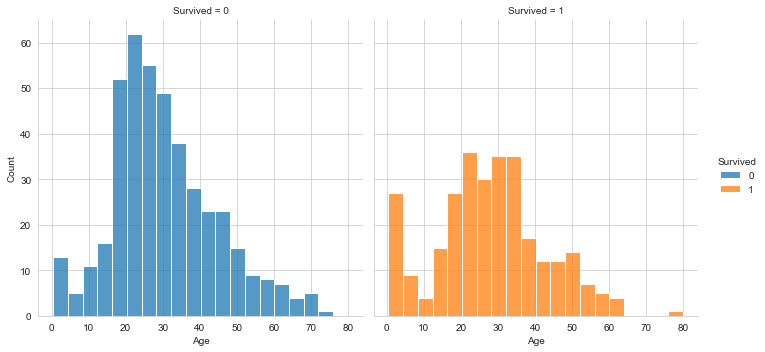

In [14]:
sns.displot(data=ds_titanic_src, x='Age', hue='Survived', col='Survived');

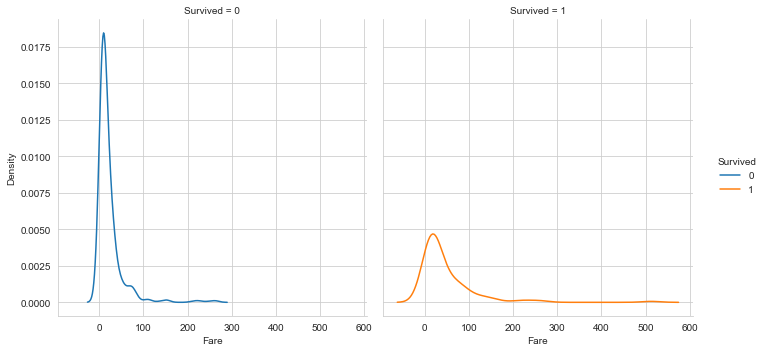

In [15]:
sns.displot(data=ds_titanic_src, x='Fare', hue='Survived', col='Survived', kind='kde');

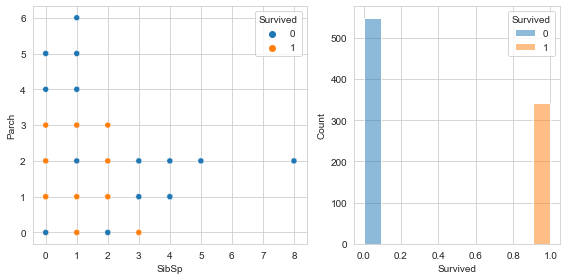

In [16]:
f, axs = plt.subplots(1,2, figsize=(8,4), gridspec_kw = dict(width_ratios=[4,3]))
sns.scatterplot(data=ds_titanic_src, x='SibSp', y='Parch', hue='Survived', ax=axs[0])
sns.histplot(data=ds_titanic_src, x='Survived', hue='Survived', ax=axs[1])
f.tight_layout()

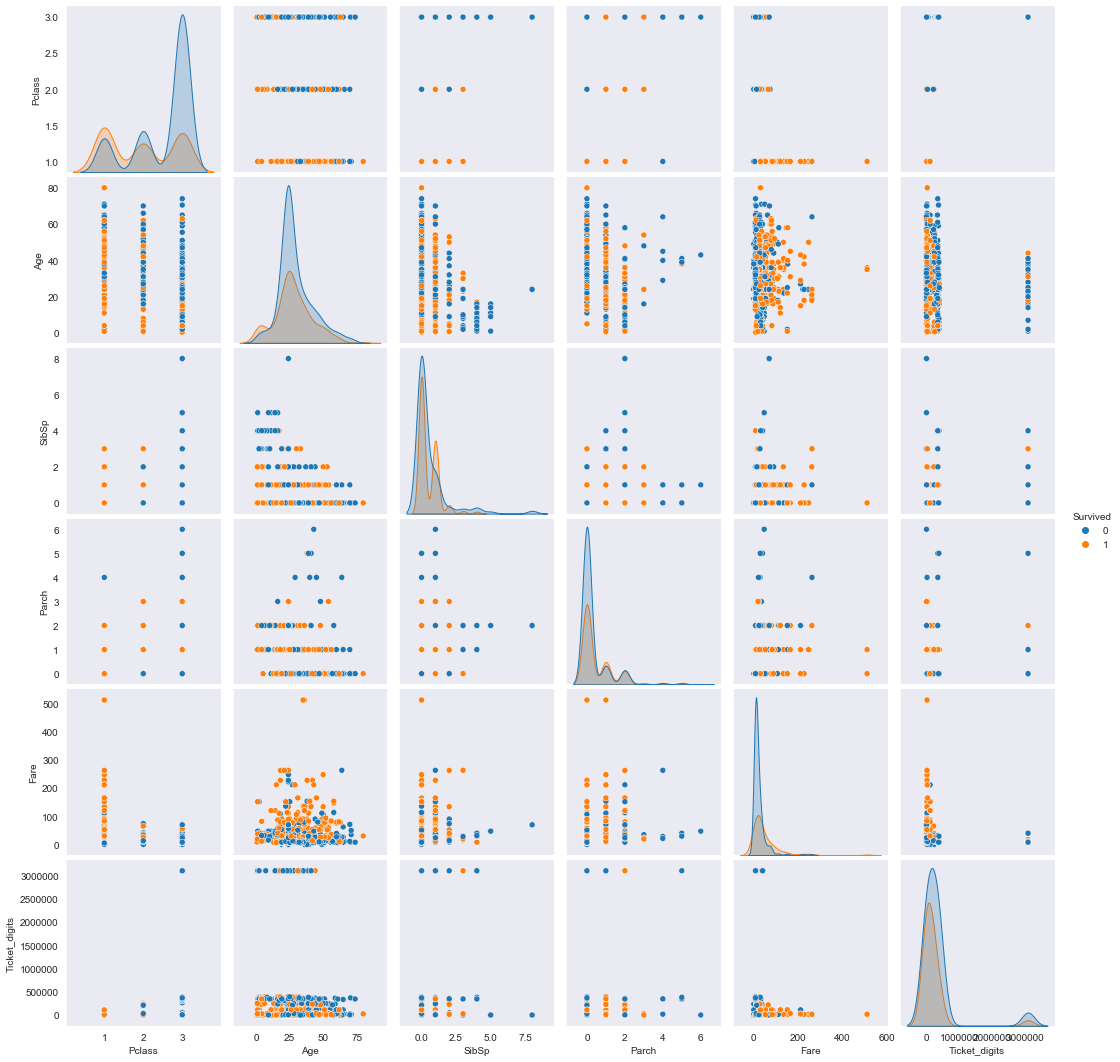

In [17]:
sns.set_style('dark')
sns.pairplot(data = ds_titanic_src2, hue='Survived')

#trend: Pclass lower has more survival
#Age survival rate could be spread
#SibSp: sibSp between 0 to 1 has higher survival than more than 1; SibSp with Pclass=1 has highest survival rate
# high fare has lower pclass, has more survival
# lower ticket digit has survival rate 



C:\Users\sherry.gow\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

66.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\sherry.gow\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

43.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



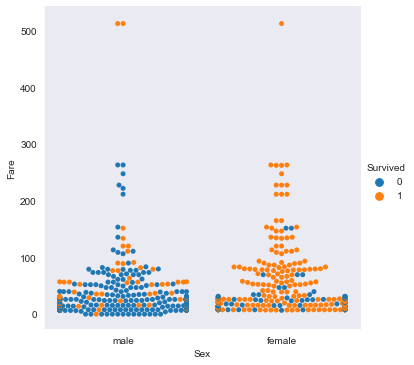

In [18]:
sns.catplot(x='Sex', y='Fare', hue='Survived', kind='swarm', data=ds_titanic_src)
# more female survived than mail

C:\Users\sherry.gow\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1282: RuntimeWarning:

invalid value encountered in less

C:\Users\sherry.gow\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\categorical.py:1286: RuntimeWarning:

invalid value encountered in greater



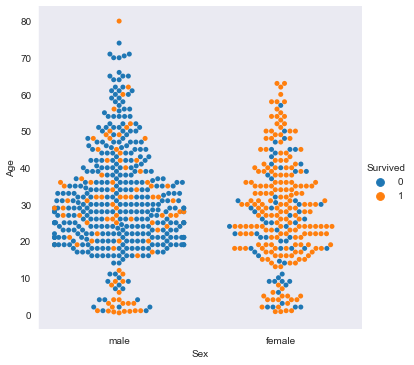

In [19]:
sns.catplot(x='Sex', y='Age', hue='Survived', kind='swarm', data=ds_titanic_src);

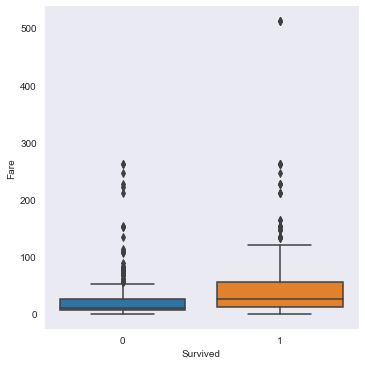

In [20]:
sns.catplot(x='Survived', y='Fare', kind='box', data=ds_titanic_src)

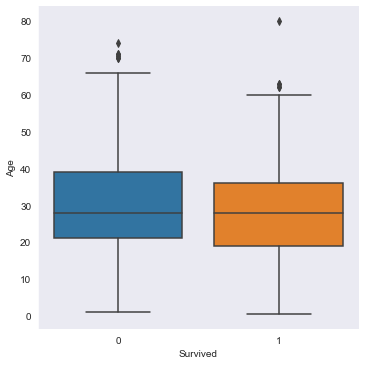

In [21]:
sns.catplot(x='Survived', y='Age', kind='box', data=ds_titanic_src)

In [61]:
#for Pclass - transfer to one hot encoding
dlist =['Pclass', 'Sex', 'Embarked']
for item in dlist:
    df_dummy = pd.get_dummies(ds_titanic_src2[item], prefix=item)
    ds_titanic_src2 = pd.concat([ds_titanic_src2, df_dummy], axis=1)
    ds_titanic_src2.drop(item, axis=1,inplace=True)

for item in dlist:
    df_dummy =pd.get_dummies(ds_titanic_test[item], prefix=item) 
    ds_titanic_test = pd.concat([ds_titanic_test, df_dummy], axis=1)
    ds_titanic_test.drop(item, axis=1,inplace=True)


In [62]:
ds_titanic_src2

Survived   Age  SibSp  Parch     Fare  Ticket_digits  Pclass_1  \
PassengerId                                                                   
1                   0  22.0      1      0   7.2500          21171         0   
2                   1  38.0      1      0  71.2833          17599         1   
3                   1  26.0      0      0   7.9250        3101282         0   
4                   1  35.0      1      0  53.1000         113803         1   
5                   0  35.0      0      0   8.0500         373450         0   
...               ...   ...    ...    ...      ...            ...       ...   
887                 0  27.0      0      0  13.0000         211536         0   
888                 1  19.0      0      0  30.0000         112053         1   
889                 0  24.0      1      2  23.4500           6607         0   
890                 1  26.0      0      0  30.0000         111369         1   
891                 0  32.0      0      0   7.7500         370376         0   

             Pclass_2  Pclass_3  Sex_female  Sex_male  Embarked_C  Embarked_Q  \
PassengerId                                                                     
1                   0         1           0         1           0           0   
2                   0         0           1         0           1           0   
3                   0         1           1         0           0           0   
4                   0         0           1         0           0           0   
5                   0         1           0         1           0           0   
...               ...       ...         ...       ...         ...         ...   
887                 1         0           0         1           0           0   
888                 0         0           1         0           0           0   
889                 0         1           1         0           0           0   
890                 0         0           0         1           1           0   
891                 0         1           0         1           0           1   

             Embarked_S  
PassengerId              
1                     1  
2                     0  
3                     1  
4                     1  
5                     1  
...                 ...  
887                   1  
888                   1  
889                   1  
890                   0  
891                   0  

[891 rows x 14 columns]

In [63]:
col =['Age', 'SibSp', 'Parch','Fare','Ticket_digits']
scaler =MinMaxScaler()
fare_tran = scaler.fit_transform(ds_titanic_src2)
fare_test = scaler.fit_transform(ds_titanic_test)



In [64]:
fare_tran

array([[0.        , 0.27117366, 0.125     , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.4722292 , 0.125     , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.32143755, 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.2963056 , 0.125     , ..., 0.        , 0.        ,
        1.        ],
       [1.        , 0.32143755, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.39683338, 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [65]:
#line up index
rw, cl = ds_titanic_src2.shape
idx = ds_titanic_src2.index
ds_titanic_src3= pd.DataFrame(fare_tran,columns=ds_titanic_src2.columns, index=idx)
 
col_cat =['Survived', 'Pclass_1', 'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
ds_titanic_train = ds_titanic_src2[col_cat].join(ds_titanic_src3[col])
ds_titanic_train


Survived  Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  \
PassengerId                                                                 
1                   0         0         0         1           0         1   
2                   1         1         0         0           1         0   
3                   1         0         0         1           1         0   
4                   1         1         0         0           1         0   
5                   0         0         0         1           0         1   
...               ...       ...       ...       ...         ...       ...   
887                 0         0         1         0           0         1   
888                 1         1         0         0           1         0   
889                 0         0         0         1           1         0   
890                 1         1         0         0           0         1   
891                 0         0         0         1           0         1   

             Embarked_C  Embarked_Q  Embarked_S       Age  SibSp     Parch  \
PassengerId                                                                  
1                     0           0           1  0.271174  0.125  0.000000   
2                     1           0           0  0.472229  0.125  0.000000   
3                     0           0           1  0.321438  0.000  0.000000   
4                     0           0           1  0.434531  0.125  0.000000   
5                     0           0           1  0.434531  0.000  0.000000   
...                 ...         ...         ...       ...    ...       ...   
887                   0           0           1  0.334004  0.000  0.000000   
888                   0           0           1  0.233476  0.000  0.000000   
889                   0           0           1  0.296306  0.125  0.333333   
890                   1           0           0  0.321438  0.000  0.000000   
891                   0           1           0  0.396833  0.000  0.000000   

                 Fare  Ticket_digits  
PassengerId                           
1            0.014151       0.006826  
2            0.139136       0.005675  
3            0.015469       0.999989  
4            0.103644       0.036695  
5            0.015713       0.120417  
...               ...            ...  
887          0.025374       0.068208  
888          0.058556       0.036131  
889          0.045771       0.002130  
890          0.058556       0.035910  
891          0.015127       0.119425  

[891 rows x 14 columns]

In [66]:
#line up index
rw, cl = ds_titanic_test.shape
idx = ds_titanic_test.index
# ds_titanic_test.index 
ds_titanic_test2= pd.DataFrame(fare_test,columns=ds_titanic_test.columns, index=idx)
 
col_cat =['Pclass_1', 'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
ds_titanic_test3 = ds_titanic_test[col_cat].join(ds_titanic_test2[col])
ds_titanic_test3

Pclass_1  Pclass_2  Pclass_3  Sex_female  Sex_male  Embarked_C  \
PassengerId                                                                   
892                 0         0         1           0         1           0   
893                 0         0         1           1         0           0   
894                 0         1         0           0         1           0   
895                 0         0         1           0         1           0   
896                 0         0         1           1         0           0   
...               ...       ...       ...         ...       ...         ...   
1305                0         0         1           0         1           0   
1306                1         0         0           1         0           1   
1307                0         0         1           0         1           0   
1308                0         0         1           0         1           0   
1309                0         0         1           0         1           1   

             Embarked_Q  Embarked_S       Age  SibSp     Parch      Fare  \
PassengerId                                                                
892                   1           0  0.452723  0.000  0.000000  0.015282   
893                   0           1  0.617566  0.125  0.000000  0.013663   
894                   1           0  0.815377  0.000  0.000000  0.018909   
895                   0           1  0.353818  0.000  0.000000  0.016908   
896                   0           1  0.287881  0.125  0.111111  0.023984   
...                 ...         ...       ...    ...       ...       ...   
1305                  0           1  0.314256  0.000  0.000000  0.015713   
1306                  0           0  0.512066  0.000  0.000000  0.212559   
1307                  0           1  0.505473  0.000  0.000000  0.014151   
1308                  0           1  0.314256  0.000  0.000000  0.015713   
1309                  0           0  0.314256  0.125  0.111111  0.043640   

             Ticket_digits  
PassengerId                 
892               0.106700  
893               0.117134  
894               0.077475  
895               0.101619  
896               0.999995  
...                    ...  
1305              0.001043  
1306              0.005725  
1307              0.999983  
1308              0.115856  
1309              0.000860  

[418 rows x 13 columns]

In [67]:
X=ds_titanic_train[['Pclass_1', 'Pclass_2','Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Age', 'SibSp', 'Parch','Fare','Ticket_digits']]
y=ds_titanic_train['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
# y_train['Survived'] = y_train['Survived'].astype('object')
# y_test['Survived'] = y_test['Survived'].astype('object')

In [68]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(623, 13)
(268, 13)
(623,)
(268,)


In [69]:
ds_titanic_test3.to_csv('test_etl.csv')

In [70]:
clf = RandomForestClassifier (n_estimators=100)
clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [71]:
y_pred = clf.predict(X_test)
print("Accuracy Random Forest: ", metrics.accuracy_score(y_test, y_pred))

Accuracy Random Forest:  0.8283582089552238


In [79]:
y_pred_test =clf.predict(ds_titanic_test3)
idx= ds_titanic_test3.index
pd.DataFrame(y_pred_test,columns=['Survived'] ,index=idx).to_csv('test_RF.csv')

In [ ]:
ds_titanic_test3.index

In [80]:
clf_ada = AdaBoostClassifier(n_estimators=100)
clf_ada.fit(X_train, y_train)
y_pred = clf_ada.predict(X_test)
print("Accuracy Ada boost: ", metrics.accuracy_score(y_test, y_pred))

Accuracy Ada boost:  0.7723880597014925


In [81]:
y_pred_test =clf_ada.predict(ds_titanic_test3)
pd.DataFrame(y_pred_test,columns=['Survived'] ,index=idx).to_csv('test_ADA.csv')

In [82]:
clf_xgb = xgb.XGBClassifier (colsample_bytree=1, learning_rate = 0.05, max_depth = 5, alpha = 10, n_estimator = 50)
clf_xgb.fit(X_train, y_train)
y_pred = clf_xgb.predict(X_test)
print("Accuracy xg boost: ", metrics.accuracy_score(y_test, y_pred))

C:\Users\sherry.gow\AppData\Local\Continuum\anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

[00:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:25:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bin

In [83]:
y_pred_test =clf_xgb.predict(ds_titanic_test3)
pd.DataFrame(y_pred_test,columns=['Survived'] ,index=idx).to_csv('test_xgb.csv')

Below is using CV and grid search

In [84]:
def algorithm_pipeline(X_train, X_test, y_train, y_test, 
                       model, param_grid, cv=10, scoring_fit='logloss',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_trai, y_train)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test)
    else:
      pred = fitted_model.predict(X_test)
    
    return fitted_model, pred

In [89]:
#let's try XGBClassifier grid search
clf_xgb2 = xgb.XGBClassifier()
param_grid = {
    'n_estimators': [40,50,100,250],
    'colsample_bytree': [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'max_depth': [5,10,15,20,25],
    'reg_alpha': [1.1,1.2,1.3],
    'reg_lambda':[1.1,1.2,1.3],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1]
}

clf_xgb2, pred = algorithm_pipeline(X_train, X_test, y_train, y_test, clf_xgb2, param_grid, cv=5)
print(np.sqrt(-model.best_score_))
print(model.best_params_)

NameError: name 'X_train_data' is not defined